# Cloud masking with Sentinel Hub and s2cloudless

Notebook showing how to get cloud masks from [Sentinel Hub services](https://medium.com/sentinel-hub/cloud-masks-at-your-service-6e5b2cb2ce8a), or compute them locally using `mask.eotask_cloud_mask` module.

In [1]:
%matplotlib inline

import datetime as datetime

import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import FeatureType
from eolearn.io import SentinelHubInputTask
from eolearn.mask import CloudMaskTask
from sentinelhub import CRS, BBox, DataCollection

Define ROI BBOX and time interval, in this case a bounding box around Ljubljana, February - May 2020.

In [2]:
roi_bbox = BBox([14.218369, 46.007455, 14.71344, 46.271275], crs=CRS.WGS84)

time_interval = ("2020-02-01", "2020-05-01")

### Use Sentinel Hub precomputed cloud masks and cloud probabilities

This task will download RGB Sentinel-2 bands together with CLM and CLP bands. See [blog](https://medium.com/sentinel-hub/cloud-masks-at-your-service-6e5b2cb2ce8a) on cloud masks available on Sentinel Hub. 

The downloaded masks will be stored in 
  * `CLM` - cloud mask
  * `CLP` - cloud pseudo-probabilities

In [3]:
input_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=["B02", "B03", "B04"],
    bands_feature=(FeatureType.DATA, "bands"),
    additional_data=[(FeatureType.MASK, "dataMask"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    resolution=(160, 160),
    time_difference=datetime.timedelta(hours=2),
    max_threads=3,
)

In [4]:
%%time
eopatch = input_task.execute(bbox=roi_bbox, time_interval=time_interval)

CPU times: user 2.03 s, sys: 215 ms, total: 2.25 s
Wall time: 5.58 s


Next we select an index in time indices and implement helper function `plot`.

In [5]:
def plot(eopatch, timestamp_idx, feat_true_color, true_color_bands, feat_CLP, feat_CLM, text):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    ax[0].imshow((eopatch[feat_true_color][timestamp_idx][..., true_color_bands] / 1.1251))
    ax[1].imshow(np.squeeze(eopatch[feat_CLP][timestamp_idx]), cmap="gray")
    ax[2].imshow(np.squeeze(eopatch[feat_CLM][timestamp_idx]), cmap="gray")

    ax[1].set_title(
        "True color, cloud probabilities and cloud masks for"
        f" {eopatch.timestamp[timestamp_idx].date().isoformat()} {text}"
    );

In [6]:
feat_bands = (FeatureType.DATA, "bands")
feat_CLP = (FeatureType.DATA, "CLP")
feat_CLM = (FeatureType.MASK, "CLM")
timestamp_idx = 11
bands = [2, 1, 0]

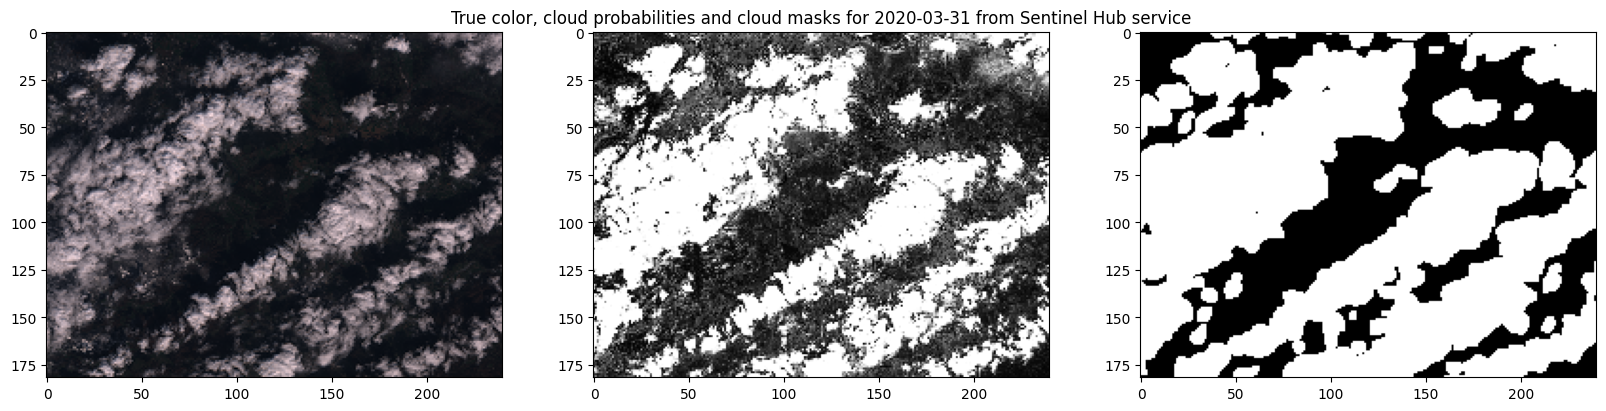

In [7]:
plot(
    eopatch,
    timestamp_idx,
    feat_bands,
    bands,
    feat_CLP,
    feat_CLM,
    "from Sentinel Hub service",
)

### Compute cloud maps yourself

In this example, the cloud maps are computed locally by requesting bands from service and running [S2Cloudless](https://github.com/sentinel-hub/sentinel2-cloud-detector).  

In [8]:
download_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B10", "B11", "B12"],
    bands_feature=(FeatureType.DATA, "bands"),
    additional_data=[(FeatureType.MASK, "dataMask")],
    resolution=(160, 160),
    time_difference=datetime.timedelta(hours=2),
    max_threads=3,
)

add_clm = CloudMaskTask(
    data_feature=(FeatureType.DATA, "bands"),
    is_data_feature=(FeatureType.MASK, "dataMask"),
    mono_features=("CLP", "CLM"),
    mask_feature=None,
    processing_resolution="160m",
)

Execute `SentinelHubInputTask` and `CloudMaskTask`:

In [9]:
%%time
eopatch_clm = download_task.execute(bbox=roi_bbox, time_interval=time_interval)
eopatch_clm = add_clm.execute(eopatch_clm)

CPU times: user 25.7 s, sys: 572 ms, total: 26.2 s
Wall time: 11.5 s


Plot results

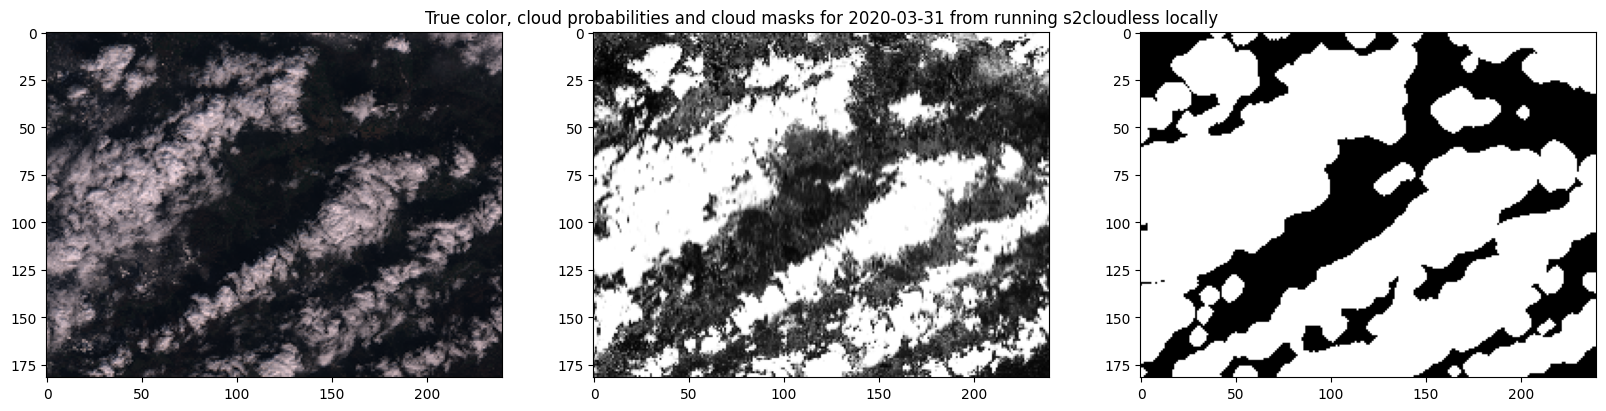

In [10]:
plot(
    eopatch_clm,
    timestamp_idx,
    feat_bands,
    [x + 1 for x in bands],
    feat_CLP,
    feat_CLM,
    "from running s2cloudless locally",
)

### Multi-temporal cloud masks

The `CloudMaskTask` also supports multi-temporal cloud masking, taking several observations into account when calculating masks for any given observation. As we have already all the data available, we'll just create the task and execute it on the `eopatch_clm`. For possible comparison with mono-temporal masks, we'll append the multi-temporal cloud masks and pseudoprobabilities with `_multi`. 

In [11]:
add_multitemporal_clm = CloudMaskTask(
    data_feature=(FeatureType.DATA, "bands"),
    is_data_feature=(FeatureType.MASK, "dataMask"),
    multi_features=("CLP_multi", "CLM_multi"),
    mask_feature=None,
    processing_resolution="160m",
)

In [12]:
%%time
eopatch_clm_multi = add_multitemporal_clm.execute(eopatch_clm)

CPU times: user 1min 20s, sys: 182 ms, total: 1min 20s
Wall time: 9.38 s


In [13]:
feat_CLP_multi = (FeatureType.DATA, "CLP_multi")
feat_CLM_multi = (FeatureType.MASK, "CLM_multi")

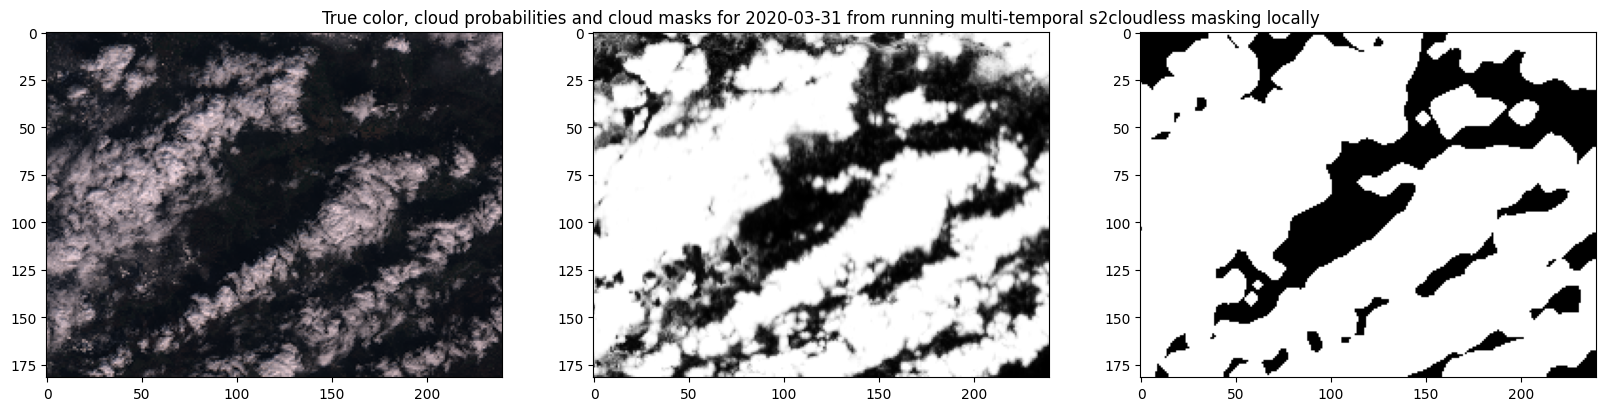

In [14]:
plot(
    eopatch_clm_multi,
    timestamp_idx,
    feat_bands,
    [x + 1 for x in bands],
    feat_CLP_multi,
    feat_CLM_multi,
    "from running multi-temporal s2cloudless masking locally",
);

### Before you go

Using cloud masks provided by the service suffices for most use cases, driving down the cost of your processing while being faster. You might have noticed the `%%time` magic command used throughout the notebook; in my case, the comparison of the three approaches shows:
 * Sentinel Hub services:   
     `CPU times: user 1.95 s, sys: 240 ms, total: 2.19 s`
 * mono-temporal cloud mask   
     `CPU times: user 25.6 s, sys: 368 ms, total: 26 s`
 * multi-temporal cloud masking   
     `CPU times: user 1min 20s, sys: 192 ms, total: 1min 21s`

Unless Sentinel Hub provided cloud masks are not sufficient in your use case, we strongly incourage you to use them. Please see the [blog post](https://medium.com/sentinel-hub/cloud-masks-at-your-service-6e5b2cb2ce8a) for details.